# Kaggle Facial Keypoints Detection with Keras

This is a replica of [This blog in Japanese](https://elix-tech.github.io/ja/2016/06/02/kaggle-facial-keypoints-ja.html), many thanks to [Shinya Yuki](https://twitter.com/tuntuku_sy)

## Memo

[The original Daniel Nouri's implementation](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/) was built on [Lasagne](https://github.com/benanne/Lasagne), a library for the obsolete deep learning framework [Theano](http://deeplearning.net/software/theano/).

## Dataset

[Kaggle](https://www.kaggle.com) holds facial keypoints detection competition and all you need is [here](https://www.kaggle.com/c/facial-keypoints-detection/data)

dataset  | num   | resolution | color     | keypoints
---      | ---   | ---        | ---       | ---
Training | 7049  | 96x96      | grayscale | 15

![An example of one of the faces with three keypoints marked.](image_1.png)
An example of one of the faces with three keypoints marked.

## loading data

Both image pixels and keypoints are in CSV files, and pixels are stored in 'Image' column and separated by space. The function load both the traning and the test data, and the differece of which is that the test data doesn't contain the target values.

In [1]:
# dependencies

import os

import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

# loading training and testing data from csv

FTRAIN = 'training.csv'
FTEST  = 'test.csv'

def load(test=False, cols=None):
    
    fname = FTEST if test else FTRAIN
    df = read_csv(fname)    # read CSV with pandas

    # Transfor'Image'column seperated by space to numpy arrays
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # holds 'Image' and designated columns only
        df = df[list(cols) + ['Image']]

    print(df.count())       # counts of data in each column
    df = df.dropna()        # holds rows with all keypoints only

    # transform'image' arrays vertically, and normalize grayscale in[0,1]
    X = np.vstack(df['Image'].values) / 255.
    X = X.astype(np.float32)            # transform to float32 arrays

    if not test:
        y = df[df.columns[:-1]].values  # columns without 'image'
        y = (y - 48) / 48   # (with origin at center）rescale coordinates 
                            # to [-1, 1](from[0,95])
        X, y = shuffle(X, y,            # (X,y) still matches repectively
                       random_state=42) # random.seed
        y = y.astype(np.float32)
    else:
        y = None

    return X, y                         # return image and points(if not test)

In [12]:
# loading data

X, y = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
      X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
      y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

### Explaination

1. After dropna() leaves 2140 samples only, which may cause overfitting because input-dimension(96x96=9216) is much more than the prior
1. Normalise (X,y) to [-1,1] may help reduce unexpected error


## Model 1 - single hidden layer

A simple NN with only one hidden layer consumes less CPU time

In [13]:
# 1-hidden-layer NN

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

model = Sequential()                # sequential object
model.add(Dense(100,                # fully-connected layer with 100 nodes
                input_dim=9216))
model.add(Activation('relu'))       # Relu activation
model.add(Dense(30))                # fully-connected layer with 100 nodes

sgd = SGD(lr=0.01,                  # customized optimizer
          momentum=0.9, 
          nesterov=True)
model.compile(loss='mean_squared_error', # loss function
              optimizer=sgd)             # customized optimizer
model.summary()                          # show NN structure
hist = model.fit(X, y, 
                 nb_epoch=100,           # epochs
                 validation_split=0.2)   # 20% training sample for validation

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               921700    
_________________________________________________________________
activation_11 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 30)                3030      
Total params: 924,730
Trainable params: 924,730
Non-trainable params: 0
_________________________________________________________________
Train on 1712 samples, validate on 428 samples
Epoch 1/100


C:\Users\denti\Anaconda3\envs\tf\lib\site-packages\keras\models.py:874: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


1712/1712 [==============================] - 1s 393us/step - loss: 0.0538 - val_loss: 0.0203
Epoch 2/100
1712/1712 [==============================] - 0s 290us/step - loss: 0.0130 - val_loss: 0.0114
Epoch 3/100
1712/1712 [==============================] - 0s 292us/step - loss: 0.0108 - val_loss: 0.0109
Epoch 4/100
1712/1712 [==============================] - 1s 298us/step - loss: 0.0101 - val_loss: 0.0098
Epoch 5/100
1712/1712 [==============================] - 0s 290us/step - loss: 0.0093 - val_loss: 0.0092
Epoch 6/100
1712/1712 [==============================] - 0s 289us/step - loss: 0.0087 - val_loss: 0.0103
Epoch 7/100
1712/1712 [==============================] - 1s 293us/step - loss: 0.0084 - val_loss: 0.0086
Epoch 8/100
1712/1712 [==============================] - 0s 292us/step - loss: 0.0081 - val_loss: 0.0086
Epoch 9/100
1712/1712 [==============================] - 0s 292us/step - loss: 0.0077 - val_loss: 0.0079
Epoch 10/100
1712/1712 [==============================] - 0s 291us/

### Visualize loss function

Use 'history' attribute of the model，and plot acc/loss tab

In [1]:
# Visualise

% matplotlib inline
from matplotlib import pyplot

pyplot.plot(hist.history['loss'],        # loss function
            linewidth=2, 
            label='train set')
pyplot.plot(hist.history['val_loss'], 
            linewidth=2,
            label='valid set')
pyplot.grid()                            # show metrics(0, 20, 40...)
pyplot.legend()                          # show legend
pyplot.xlabel('epoch')                   # x label
pyplot.ylabel('loss')                    # y label
# pyplot.ylim(1e-3, 1e-2)                  # y limitation
pyplot.yscale('log')                     # y scaling
pyplot.show()                            # show the diagram

NameError: name 'hist' is not defined

## Prediction

In [16]:
# prediction

X_test, _ = load(test=True)
y_test = model.predict(X_test)

# add runtime later

ImageId    1783
Image      1783
dtype: int64


image 773 to 789


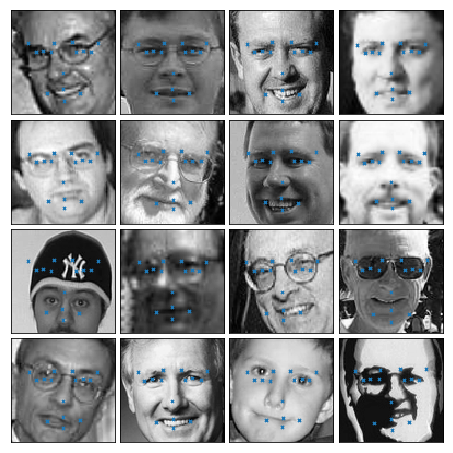

In [18]:
# show

from random import randint
from matplotlib import pyplot

def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

fig = pyplot.figure(figsize=(6, 6))
fig.subplots_adjust(left=0,
                    right=1,
                    bottom=0,
                    top=1,
                    hspace=0.05,
                    wspace=0.05)

numofImages = X_test.shape[0]
num = randint(0, numofImages-16)
print('image',num,'to',num+16)

for i in range(num, num+16):
    axis = fig.add_subplot(4, 4, i-num+1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_test[i], axis)

pyplot.show()

### Saving and loading models

In [28]:
# save model

json_string = model.to_json()
open('model1_architecture.json', 'w').write(json_string)  # structural
model.save_weights('model1_weights.h5')                   # weights

# load model

# from keras.models import model_from_json
# model = model_from_json(open('model1_architecture.json').read())
# model.load_weights('model1_weights.h5')

## Model 2 - CNN

Ingrediants：convolutional layers，pooling layers，dense(fully connected) layers

1. Convolutional layers: learning weights
![Conv feature](image_2.gif)

2. Pooling layers：max or average pooling, reduce complexity
![MaxPooling](image_3.jpg)

3. Dense(fully connected) layers：connected to all nodes in the last layer, only 1 dimension arrays accepted.

In [3]:
# convert input-dim to (96,96,1)

def load2d(test=False, cols=None):
    X, y = load(test, cols)
    X = X.reshape(-1, 96, 96, 1)
    return X, y

X, y = load2d()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
      X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
      y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [4]:
# Model 2: CNN

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

from keras.layers import Convolution2D, MaxPooling2D, Flatten


model3 = Sequential()

model3.add(Convolution2D(32, 3, 3,
                         input_shape=(96, 96, 1)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Convolution2D(64, 2, 2))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Convolution2D(128, 2, 2))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())
model3.add(Dense(500))
model3.add(Activation('relu'))
model3.add(Dense(500))
model3.add(Activation('relu'))
model3.add(Dense(30))

sgd = SGD(lr=0.01,
          momentum=0.9, 
          nesterov=True)   
model3.compile(loss='mean_squared_error',
               optimizer=sgd)
model3.summary()
hist3 = model3.fit(X, y, 
                   epochs=20,
                   validation_split=0.2)

C:\Users\denti\Anaconda3\envs\tf\lib\site-packages\ipykernel\__main__.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(96, 96, 1...)`
C:\Users\denti\Anaconda3\envs\tf\lib\site-packages\ipykernel\__main__.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (2, 2))`
C:\Users\denti\Anaconda3\envs\tf\lib\site-packages\ipykernel\__main__.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (2, 2))`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
activation_6 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 46, 46, 64)        8256      
_________________________________________________________________
activation_7 (Activation)    (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 128)       32896     
__________

In [2]:
# Visualise

% matplotlib inline
from matplotlib import pyplot

pyplot.plot(hist3.history['loss'],        # loss function
            linewidth=2, 
            label='train set')
pyplot.plot(hist3.history['val_loss'], 
            linewidth=2,
            label='valid set')
pyplot.grid()                            # show metrics(0, 20, 40...)
pyplot.legend()                          # show legend
pyplot.xlabel('epoch')                   # x label
pyplot.ylabel('loss')                    # y label
# pyplot.ylim(1e-3, 1e-2)                  # y limitation
pyplot.yscale('log')                     # y scaling
pyplot.show()                            # show the diagram

NameError: name 'hist3' is not defined

In [19]:
# prediction

X_test, _ = load2d(test=True)
y_test = model3.predict(X_test)

ImageId    1783
Image      1783
dtype: int64


image 405 to 421


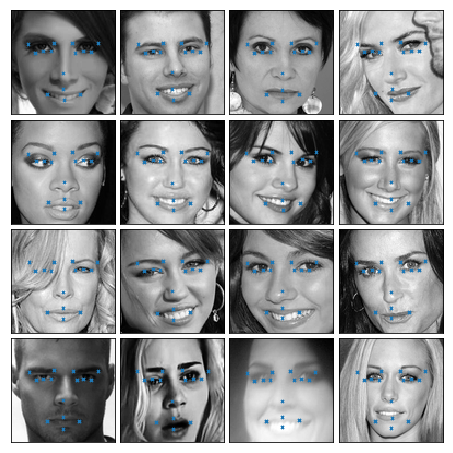

In [25]:
# show

from matplotlib import pyplot
from random import randint

def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)
    
fig = pyplot.figure(figsize=(6, 6))
fig.subplots_adjust(left=0,
                    right=1,
                    bottom=0,
                    top=1,
                    hspace=0.05,
                    wspace=0.05)

numofImages = X_test.shape[0]
num = randint(0, numofImages-16)
print('image',num,'to',num+16)

for i in range(num, num+16):
    axis = fig.add_subplot(4, 4, i-num+1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_test[i], axis)

pyplot.show()

In [22]:
# Compare 2 models

# Load All Samples

from matplotlib import pyplot
from random import randint

AllSample1 = load(test=True)[0]
AllSample2 = load2d(test=True)[0]

ImageId    1783
Image      1783
dtype: int64
ImageId    1783
Image      1783
dtype: int64


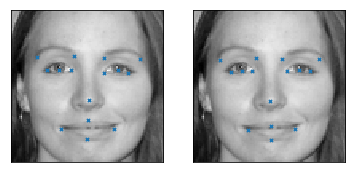

In [27]:
# predict both

num = randint(0, X_test.shape[0])
sample1 = AllSample1[num:num+1]
sample2 = AllSample2[num:num+1]
y_pred1 = model.predict(sample1)[0]
y_pred2 = model3.predict(sample2)[0]

fig = pyplot.figure(figsize=(6, 3))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_sample(sample1, y_pred1, ax)
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_sample(sample2, y_pred2, ax)
pyplot.show()

In [29]:
# save model

json_string = model3.to_json()
open('model3_architecture.json', 'w').write(json_string)  # structural
model.save_weights('model3_weights.h5')                   # weights

# load model

# from keras.models import model_from_json
# model = model_from_json(open('model1_architecture.json').read())
# model.load_weights('model1_weights.h5')